In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr, spearmanr, kendalltau
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

# Data Preparation

## Data Imports

### Flow Data

In [2]:
flow_predictions = pd.read_csv('./results/yt_analysis/results.csv')
flow_predictions['VID'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[0].split('/')[-1]))
flow_predictions['FRAME'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[-4]))
flow_predictions['FLOW_C'] = flow_predictions.FILE.apply(lambda x: int(x.split('_')[-2]))
flow_predictions.drop(columns=['FILE'], inplace=True)
flow_predictions.loc[flow_predictions['PROB'] >= 0.5, 'FLOW_P_C'] = int(1)
flow_predictions.loc[flow_predictions['PROB'] < 0.5, 'FLOW_P_C'] = int(0)
flow_predictions.rename(columns={'PROB':'FLOW_P'}, inplace=True)
flow_predictions.head(5)

,FLOW_P,VID,FRAME,FLOW_C,FLOW_P_C
0,0.652541,11,7258,1,1.0
1,0.518073,13,574,0,1.0
2,0.592700,12,6192,0,1.0
3,0.474445,42,7136,0,0.0
4,0.345597,19,1075,0,0.0


### Fer Private


In [3]:
fer_private = pd.read_csv('./results/yt_analysis/FER_results_private.csv').drop(columns=['FLOW'])
fer_private[['PRIVATE_ANGRY_P', 'PRIVATE_FEAR_P', 'PRIVATE_HAPPY_P', 'PRIVATE_NEUTRAL_P', 'PRIVATE_SAD_P', 'PRIVATE_SURPRISE_P']] = \
    fer_private['EMO_P'].str.strip('[').str.strip(']').str.split(' ', expand=True).loc[:,0:5].apply(pd.to_numeric, errors='coerce')
fer_private['VID'] = fer_private['VID'].astype('int')
fer_private['FRAME'] = fer_private['FRAME'].astype('int')
fer_private.rename(columns={'EMO_C':'EMO_PRIVATE'}, inplace=True)
emo_private_dummies= pd.get_dummies(fer_private['EMO_PRIVATE'],drop_first=False, prefix='PRIVATE').add_suffix('_C')
fer_private = pd.concat([fer_private, emo_private_dummies],axis=1 )
fer_private.drop(columns=['EMO_P'], inplace=True)
fer_private.head(5)

,VID,FRAME,EMO_PRIVATE,PRIVATE_ANGRY_P,PRIVATE_FEAR_P,PRIVATE_HAPPY_P,PRIVATE_NEUTRAL_P,PRIVATE_SAD_P,PRIVATE_SURPRISE_P,PRIVATE_angry_C,PRIVATE_fear_C,PRIVATE_happy_C,PRIVATE_neutral_C,PRIVATE_sad_C,PRIVATE_surprise_C
0,35,4828,neutral,1.060863e-02,5.868053e-04,0.000093,0.697780,0.250793,4.013845e-02,0,0,0,1,0,0
1,10,1000,sad,1.218641e-07,3.595444e-07,0.000002,0.001313,0.998684,4.138556e-07,0,0,0,0,1,0
2,10,1001,sad,7.561166e-07,5.696014e-06,0.000015,0.006154,0.993822,2.700594e-06,0,0,0,0,1,0
3,10,1002,sad,1.872831e-06,9.105769e-06,0.000019,0.051558,0.948405,6.697891e-06,0,0,0,0,1,0
4,10,1003,sad,1.565203e-07,4.356439e-07,0.000002,0.003426,0.996571,7.726713e-07,0,0,0,0,1,0


## Merging

In [4]:
full_df = flow_predictions.merge(fer_private, on=['VID','FRAME'])
full_df.fillna(0, inplace=True)
full_df.head(5)

,FLOW_P,VID,FRAME,FLOW_C,FLOW_P_C,EMO_PRIVATE,PRIVATE_ANGRY_P,PRIVATE_FEAR_P,PRIVATE_HAPPY_P,PRIVATE_NEUTRAL_P,PRIVATE_SAD_P,PRIVATE_SURPRISE_P,PRIVATE_angry_C,PRIVATE_fear_C,PRIVATE_happy_C,PRIVATE_neutral_C,PRIVATE_sad_C,PRIVATE_surprise_C
0,0.652541,11,7258,1,1.0,neutral,0.000181,0.000250,0.000006,0.993061,0.000229,0.006274,0,0,0,1,0,0
1,0.518073,13,574,0,1.0,sad,0.000427,0.000091,0.000173,0.024299,0.974595,0.000416,0,0,0,0,1,0
2,0.592700,12,6192,0,1.0,neutral,0.001214,0.000314,0.000592,0.927147,0.069780,0.000953,0,0,0,1,0,0
3,0.474445,42,7136,0,0.0,sad,0.000025,0.000007,0.000897,0.274898,0.722561,0.001612,0,0,0,0,1,0
4,0.345597,19,1075,0,0.0,neutral,0.001108,0.000022,0.000221,0.993751,0.004663,0.000236,0,0,0,1,0,0


In [27]:
full_df[['PRIVATE_ANGRY_P', 'PRIVATE_FEAR_P', 'PRIVATE_HAPPY_P', 'PRIVATE_NEUTRAL_P', 'PRIVATE_SAD_P', 'PRIVATE_SURPRISE_P']].sum(axis=1).describe()

count    237927.000000
mean          0.998939
std           0.023444
min           0.002654
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000002
dtype: float64

# Visual Analysis

## Flow as Class

### Predicted Class

<AxesSubplot:xlabel='EMO_PRIVATE', ylabel='FLOW_P'>

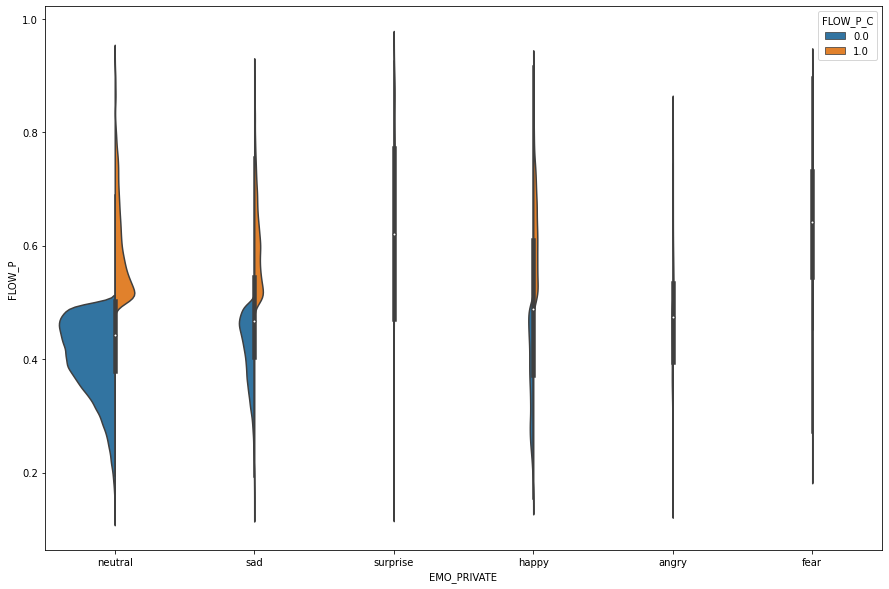

In [5]:
plt.figure(figsize=(15,10))
sns.violinplot(data=full_df[['FLOW_P_C','FLOW_P','EMO_PRIVATE']], x='EMO_PRIVATE', y='FLOW_P', hue='FLOW_P_C', split=True, scale="count", scale_hue=False)

### Labeled Class

<AxesSubplot:xlabel='EMO_PRIVATE', ylabel='FLOW_P'>

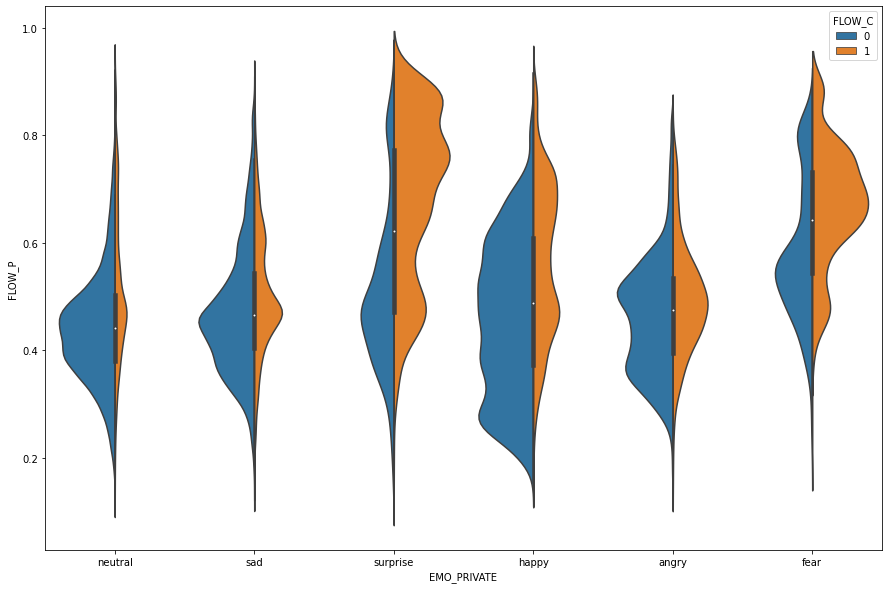

In [6]:
plt.figure(figsize=(15,10))
sns.violinplot(data=full_df[['FLOW_C','FLOW_P','EMO_PRIVATE']], x='EMO_PRIVATE', y='FLOW_P', hue='FLOW_C', split=True, scale="count")


In [ ]:
sns.pairplot(data=full_df, )

# Correlation Analysis

## Flow Probabilites

In [7]:
print('SURPRISE and FLOW:',spearmanr(full_df['FLOW_P'], full_df['PRIVATE_SURPRISE_P']))
print('FEAR and FLOW:',spearmanr(full_df['FLOW_P'], full_df['PRIVATE_FEAR_P']))
print('HAPPY and FLOW:',spearmanr(full_df['FLOW_P'], full_df['PRIVATE_HAPPY_P']))
print('ANGRY and FLOW:',spearmanr(full_df['FLOW_P'], full_df['PRIVATE_ANGRY_P']))
print('SAD and FLOW', spearmanr(full_df['FLOW_P'], full_df['PRIVATE_SAD_P']))
print('NEUTRAL and FLOW', spearmanr(full_df['FLOW_P'], full_df['PRIVATE_NEUTRAL_P']))

SURPRISE and FLOW: SpearmanrResult(correlation=0.1974074476945816, pvalue=0.0)
FEAR and FLOW: SpearmanrResult(correlation=0.24976480308101603, pvalue=0.0)
HAPPY and FLOW: SpearmanrResult(correlation=0.1289535274263289, pvalue=0.0)
ANGRY and FLOW: SpearmanrResult(correlation=0.13625830349902615, pvalue=0.0)
SAD and FLOW SpearmanrResult(correlation=0.10667400254254192, pvalue=0.0)
NEUTRAL and FLOW SpearmanrResult(correlation=-0.18610303728901137, pvalue=0.0)


## Flow Predicted Class

In [8]:
print('SURPRISE and FLOW:',spearmanr(full_df['FLOW_P_C'], full_df['PRIVATE_SURPRISE_P']))
print('FEAR and FLOW:',spearmanr(full_df['FLOW_P_C'], full_df['PRIVATE_FEAR_P']))
print('HAPPY and FLOW:',spearmanr(full_df['FLOW_P_C'], full_df['PRIVATE_HAPPY_P']))
print('ANGRY and FLOW:',spearmanr(full_df['FLOW_P_C'], full_df['PRIVATE_ANGRY_P']))
print('SAD and FLOW', spearmanr(full_df['FLOW_P_C'], full_df['PRIVATE_SAD_P']))
print('NEUTRAL and FLOW', spearmanr(full_df['FLOW_P_C'], full_df['PRIVATE_NEUTRAL_P']))

SURPRISE and FLOW: SpearmanrResult(correlation=0.18229936913460543, pvalue=0.0)
FEAR and FLOW: SpearmanrResult(correlation=0.22430186552698117, pvalue=0.0)
HAPPY and FLOW: SpearmanrResult(correlation=0.1499185064405539, pvalue=0.0)
ANGRY and FLOW: SpearmanrResult(correlation=0.13271767411120108, pvalue=0.0)
SAD and FLOW SpearmanrResult(correlation=0.07022826684815352, pvalue=8.42032914005076e-258)
NEUTRAL and FLOW SpearmanrResult(correlation=-0.18940200846821373, pvalue=0.0)


## Flow Class

In [9]:
print('SURPRISE and FLOW:',spearmanr(full_df['FLOW_C'], full_df['PRIVATE_SURPRISE_P']))
print('FEAR and FLOW:',spearmanr(full_df['FLOW_C'], full_df['PRIVATE_FEAR_P']))
print('HAPPY and FLOW:',spearmanr(full_df['FLOW_C'], full_df['PRIVATE_HAPPY_P']))
print('ANGRY and FLOW:',spearmanr(full_df['FLOW_C'], full_df['PRIVATE_ANGRY_P']))
print('SAD and FLOW', spearmanr(full_df['FLOW_C'], full_df['PRIVATE_SAD_P']))
print('NEUTRAL and FLOW', spearmanr(full_df['FLOW_C'], full_df['PRIVATE_NEUTRAL_P']))

SURPRISE and FLOW: SpearmanrResult(correlation=0.11789768175468805, pvalue=0.0)
FEAR and FLOW: SpearmanrResult(correlation=0.20503212292493156, pvalue=0.0)
HAPPY and FLOW: SpearmanrResult(correlation=0.13168113755159727, pvalue=0.0)
ANGRY and FLOW: SpearmanrResult(correlation=0.11722728560405987, pvalue=0.0)
SAD and FLOW SpearmanrResult(correlation=0.15072192047178945, pvalue=0.0)
NEUTRAL and FLOW SpearmanrResult(correlation=-0.22813392971313037, pvalue=0.0)


# Regression Analysis

In [29]:
X = full_df[['PRIVATE_ANGRY_P',  'PRIVATE_FEAR_P','PRIVATE_HAPPY_P', 'PRIVATE_NEUTRAL_P', 'PRIVATE_SAD_P', 'PRIVATE_SURPRISE_P']]
y = full_df['FLOW_P']

model = sm.OLS(y,X)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 FLOW_P   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                          6.187e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        08:48:59   Log-Likelihood:                      1.7115e+05
No. Observations:              237927   AIC:                                 -3.423e+05
Df Residuals:                  237921   BIC:                                 -3.422e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
PRIVATE_ANGRY_P        0.4758      0.002    221.809      0.000       0.472       0.480
PRIVATE_FEAR_P         0.7198      0.004    165.056      0.000       0.711       0.728
PRIVATE_HAPPY_P        0.4933      0.001    546.282      0.000       0.492       0.495
PRIVATE_NEUTRAL_P      0.4465      0.000   1425.179      0.000       0.446       0.447
PRIVATE_SAD_P          0.4842      0.001    831.698      0.000       0.483       0.485
PRIVATE_SURPRISE_P     0.6918      0.003    273.261      0.000       0.687       0.697
==============================================================================
Omnibus:                    14715.031   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19778.963
Skew:                           0.568   Prob(JB):                         0.00
Kurtosis:                       3.840   Cond. No.                         14.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

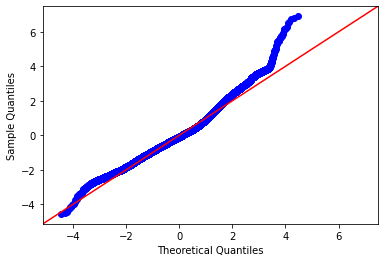

In [24]:
fig=sm.qqplot(model.resid, line='45',fit=True)

/home/janik/source/sandbox/env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

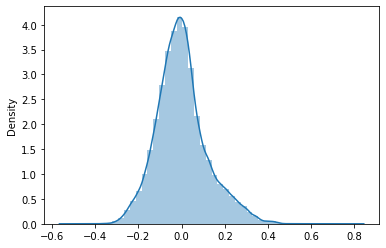

In [12]:
sns.distplot(model.resid)

In [13]:
full_df.describe()

,FLOW_P,VID,FRAME,FLOW_C,FLOW_P_C,PRIVATE_ANGRY_P,PRIVATE_FEAR_P,PRIVATE_HAPPY_P,PRIVATE_NEUTRAL_P,PRIVATE_SAD_P,PRIVATE_SURPRISE_P,PRIVATE_angry_C,PRIVATE_fear_C,PRIVATE_happy_C,PRIVATE_neutral_C,PRIVATE_sad_C,PRIVATE_surprise_C
count,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000,2.379270e+05,2.379270e+05,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000,237927.000000
mean,0.464687,31.779638,4244.522782,0.230436,0.308965,1.891606e-02,5.659965e-03,0.082938,0.656657,0.217929,0.016838,0.016930,0.004972,0.082660,0.670029,0.212843,0.012567
std,0.121232,16.512120,3234.971234,0.421113,0.462067,1.112711e-01,5.535440e-02,0.254819,0.417220,0.356952,0.094562,0.129008,0.070338,0.275368,0.470203,0.409318,0.111396
min,0.120255,1.000000,0.000000,0.000000,0.000000,1.033659e-11,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.384722,18.000000,1633.500000,0.000000,0.000000,1.425536e-06,2.180123e-07,0.000003,0.140239,0.000164,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.452344,30.000000,3554.000000,0.000000,0.000000,1.442285e-05,2.624158e-06,0.000027,0.943640,0.006139,0.000040,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.522414,46.000000,6179.000000,0.000000,1.000000,1.916726e-04,3.847822e-05,0.000622,0.998485,0.288253,0.000500,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,0.932560,60.000000,19516.000000,1.000000,1.000000,1.000000e+00,9.998215e-01,1.000000,1.000000,1.000000,0.999987,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


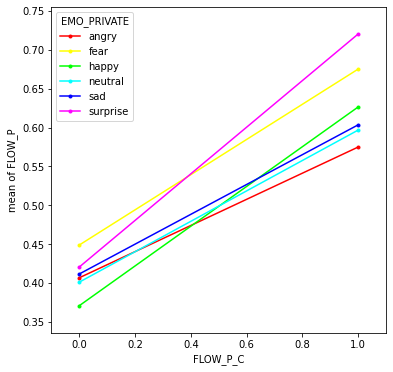

In [14]:
from statsmodels.graphics.factorplots import interaction_plot
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(x=full_df['FLOW_P_C'], trace=full_df['EMO_PRIVATE'], response=full_df['FLOW_P'],
                        ax=ax)

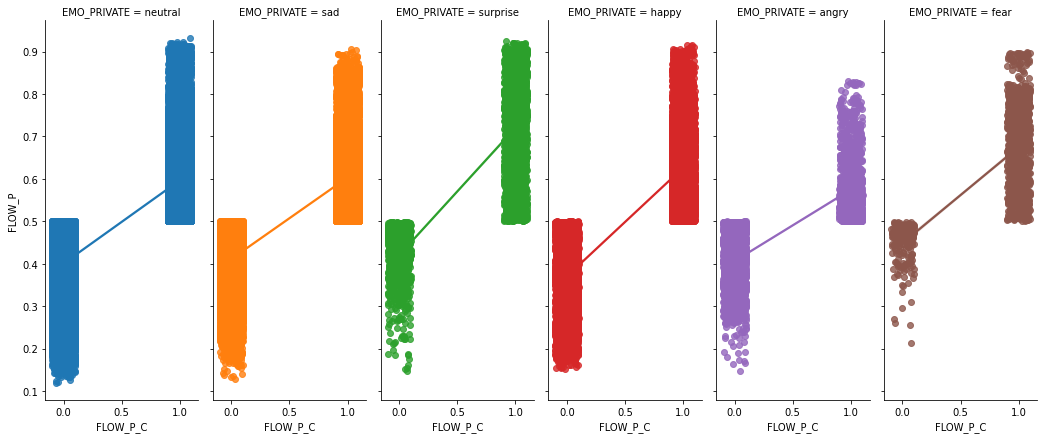

In [15]:
g = sns.lmplot(x="FLOW_P_C", y="FLOW_P", hue="EMO_PRIVATE", col="EMO_PRIVATE",
               data=full_df, height=6, aspect=.4, x_jitter=.1)


# Figures and Tables for LaTeX

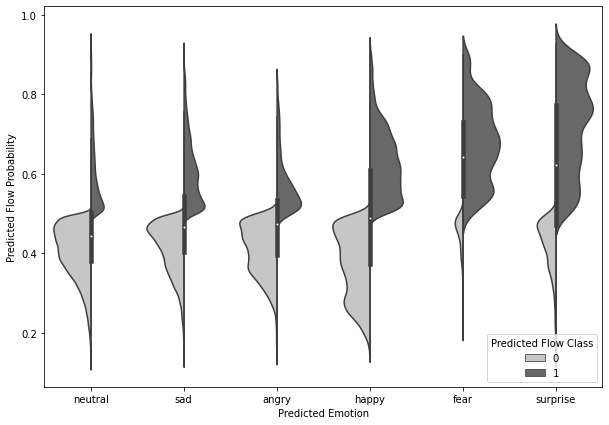

In [49]:
ORDER = ['neutral', 'sad', 'angry', 'happy', 'fear', 'surprise']

fig, ax = plt.subplots(1,1,figsize=(10,7))
full_df['FLOW_P_C'] = full_df['FLOW_P_C'].astype(int)
# sns.boxplot(data=full_df[['FLOW_P_C','FLOW_P','EMO_PRIVATE']], x='EMO_PRIVATE', y='FLOW_P', order=ORDER, palette='Greys', ax=ax)
sns.violinplot(data=full_df[['FLOW_P_C','FLOW_P','EMO_PRIVATE']], x='EMO_PRIVATE', y='FLOW_P', hue='FLOW_P_C', palette='Greys', split=True, scale="count", order=ORDER, ax=ax, legend=False)

# ax.set_title('Weighted sample distribution of predicted Flow vs Ekman emotion')
ax.set_xlabel('Predicted Emotion')
ax.set_ylabel('Predicted Flow Probability')
ax.legend(title='Predicted Flow Class', loc='lower right')

plt.show()

In [50]:
fig.savefig('emotionflow.pdf', bbox_inches='tight')

In [41]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 FLOW_P   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                          6.187e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        09:16:21   Log-Likelihood:                      1.7115e+05
No. Observations:              237927   AIC:                                 -3.423e+05
Df Residuals:                  237921   BIC:                                 -3.422e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
angry          0.4758      0.002    221.809      0.000       0.472       0.480
fear           0.7198      0.004    165.056      0.000       0.711       0.728
happy          0.4933      0.001    546.282      0.000       0.492       0.495
neutral        0.4465      0.000   1425.179      0.000       0.446       0.447
sad            0.4842      0.001    831.698      0.000       0.483       0.485
surprise       0.6918      0.003    273.261      0.000       0.687       0.697
==============================================================================
Omnibus:                    14715.031   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19778.963
Skew:                           0.568   Prob(JB):                         0.00
Kurtosis:                       3.840   Cond. No.                         14.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
import numpy as np
X = full_df[['PRIVATE_ANGRY_P',  'PRIVATE_FEAR_P','PRIVATE_HAPPY_P', 'PRIVATE_NEUTRAL_P', 'PRIVATE_SAD_P', 'PRIVATE_SURPRISE_P']].rename(columns={'PRIVATE_ANGRY_P': 'angry',  'PRIVATE_FEAR_P': 'fear', 'PRIVATE_HAPPY_P': 'happy', 'PRIVATE_NEUTRAL_P': 'neutral', 'PRIVATE_SAD_P': 'sad', 'PRIVATE_SURPRISE_P': 'surprise'})
y = full_df['FLOW_P']

model = sm.OLS(y,X)
model = model.fit()

stargazer_table = Stargazer([model])
print(stargazer_table.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable:}} \
\cr \cline{1-2}
\\[-1.8ex] & (1) \\
\hline \\[-1.8ex]
 angry & 0.476$^{***}$ \\
  & (0.002) \\
 fear & 0.720$^{***}$ \\
  & (0.004) \\
 happy & 0.493$^{***}$ \\
  & (0.001) \\
 neutral & 0.447$^{***}$ \\
  & (0.000) \\
 sad & 0.484$^{***}$ \\
  & (0.001) \\
 surprise & 0.692$^{***}$ \\
  & (0.003) \\
\hline \\[-1.8ex]
 Observations & 237,927 \\
 $R^2$ & 0.940 \\
 Adjusted $R^2$ & 0.940 \\
 Residual Std. Error & 0.118(df = 237921)  \\
 F Statistic & 618719.742$^{***}$ (df = 6.0; 237921.0) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


/home/janik/source/sandbox/env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

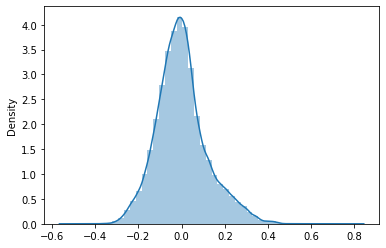

In [39]:
sns.distplot(model.resid)

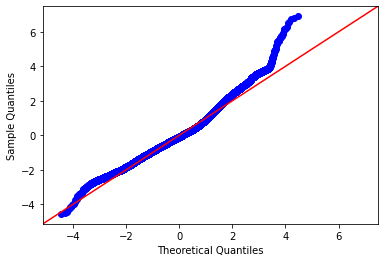

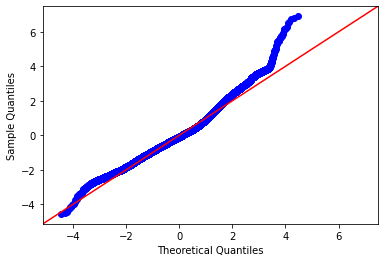

In [40]:
sm.qqplot(model.resid, line='45',fit=True)

In [90]:
print('SURPRISE and FLOW:',kendalltau(full_df['FLOW_P'], full_df['PRIVATE_SURPRISE_P']))
print('FEAR and FLOW:',kendalltau(full_df['FLOW_P'], full_df['PRIVATE_FEAR_P']))
print('HAPPY and FLOW:',kendalltau(full_df['FLOW_P'], full_df['PRIVATE_HAPPY_P']))
print('ANGRY and FLOW:',kendalltau(full_df['FLOW_P'], full_df['PRIVATE_ANGRY_P']))
print('SAD and FLOW', kendalltau(full_df['FLOW_P'], full_df['PRIVATE_SAD_P']))
print('NEUTRAL and FLOW', kendalltau(full_df['FLOW_P'], full_df['PRIVATE_NEUTRAL_P']))

SURPRISE and FLOW: KendalltauResult(correlation=0.13279263933309107, pvalue=0.0)
FEAR and FLOW: KendalltauResult(correlation=0.16767087025122188, pvalue=0.0)
HAPPY and FLOW: KendalltauResult(correlation=0.08692432904019018, pvalue=0.0)
ANGRY and FLOW: KendalltauResult(correlation=0.09016306368150015, pvalue=0.0)
SAD and FLOW KendalltauResult(correlation=0.07110786598627639, pvalue=0.0)
NEUTRAL and FLOW KendalltauResult(correlation=-0.12379023558181512, pvalue=0.0)


In [37]:
spearman_df = pd.DataFrame(columns=['spearman', 'p-value'])

In [38]:
spearman_df = spearman_df.append(pd.DataFrame([spearmanr(full_df['FLOW_P'], full_df['PRIVATE_SURPRISE_P'])], index=['surprise'], columns=['spearman', 'p-value']))
spearman_df = spearman_df.append(pd.DataFrame([spearmanr(full_df['FLOW_P'], full_df['PRIVATE_FEAR_P'])], index=['fear'], columns=['spearman', 'p-value']))
spearman_df = spearman_df.append(pd.DataFrame([spearmanr(full_df['FLOW_P'], full_df['PRIVATE_HAPPY_P'])], index=['happy'], columns=['spearman', 'p-value']))
spearman_df = spearman_df.append(pd.DataFrame([spearmanr(full_df['FLOW_P'], full_df['PRIVATE_ANGRY_P'])], index=['angry'], columns=['spearman', 'p-value']))
spearman_df = spearman_df.append(pd.DataFrame([spearmanr(full_df['FLOW_P'], full_df['PRIVATE_SAD_P'])], index=['sad'], columns=['spearman', 'p-value']))
spearman_df = spearman_df.append(pd.DataFrame([spearmanr(full_df['FLOW_P'], full_df['PRIVATE_NEUTRAL_P'])], index=['neutral'], columns=['spearman', 'p-value']))

print(spearman_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  spearman &  p-value \\
\midrule
surprise &  0.197407 &      0.0 \\
fear     &  0.249765 &      0.0 \\
happy    &  0.128954 &      0.0 \\
angry    &  0.136258 &      0.0 \\
sad      &  0.106674 &      0.0 \\
neutral  & -0.186103 &      0.0 \\
\bottomrule
\end{tabular}



In [57]:
!pip install sidetable
import sidetable as stb

In [58]:
full_df.stb.freq(['EMO_PRIVATE'])

,EMO_PRIVATE,count,percent,cumulative_count,cumulative_percent
0,neutral,159418,67.002904,159418,67.002904
1,sad,50641,21.284259,210059,88.287164
2,happy,19667,8.265981,229726,96.553144
3,angry,4028,1.692956,233754,98.246101
4,surprise,2990,1.256688,236744,99.502789
5,fear,1183,0.497211,237927,100.000000
